<a href="https://colab.research.google.com/github/rsfwalters/NEU-OB-MLP/blob/main/Clothing_Classification_with_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification of Clothing Items
In this Colab notebook, you will build and train a neural network to classify a
handwritten digit (zero through nine) in an image.  Run each cell by clicking on the play button or using keys `Shift+Enter`.  There will be some text hints and questions to help guide you through the notebook.

In [3]:
# @title Install dependencies
# import libraries for this notebook
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 1. Download Data
First, lets download the dataset.  The dataset is contains thousands of images of clothing items (shirts, pants, etc.).  In the next few code cells, you will generate some plots to better understand the dataset.  

In [8]:
%%capture
# download train and test sets
train_data = FashionMNIST(root='data', train=True, transform=ToTensor(), download=True)
test_data = FashionMNIST(root='data', train=False, transform=ToTensor(), download=True)
LABELS = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']

[__Question__] Why do you need separate data for training and testing? What would happen if we only used training data?

There are 60000 data points in train set and 10000 data points in test set.


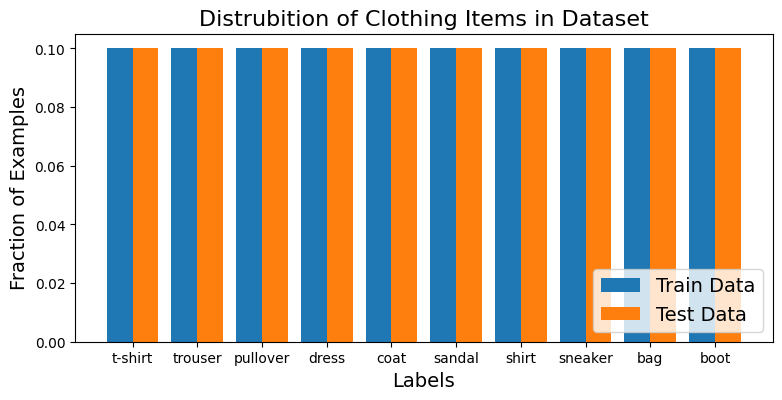

In [62]:
# print stats about datasets
print(f'There are {len(train_data)} data points in train set' \
      f' and {len(test_data)} data points in test set.')

# plot distribution of labels in train and test set
plt.figure(figsize=(9, 4))
plt.hist(train_data.targets, torch.arange(11)-0.7,
         rwidth=0.4, density=True, label='Train Data')
plt.hist(test_data.targets, torch.arange(11)-0.3,
         rwidth=0.4, density=True, label='Test Data')
plt.ylabel('Fraction of Examples', fontsize=14)
plt.xticks(torch.arange(0,10), LABELS)
plt.xlabel('Labels', fontsize=14)
plt.legend(loc='lower right', fontsize=14)
plt.title('Distribution of Clothing Items in Dataset', fontsize=16)
plt.show()

[__Question__] Why is it a good idea to have the data spread out over all labels?  

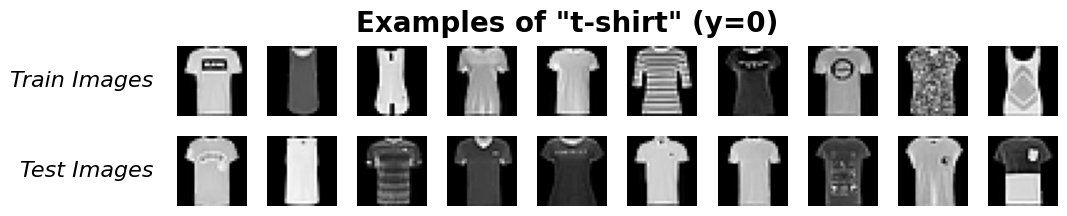

In [65]:
# @title Visualize images
def plot_examples(train_data, test_data, label):
  f, ax = plt.subplots(2, 10, figsize=(10,2))
  f.subplots_adjust(0.1, 0, 1, 0.8, wspace=0.01, hspace=0.3)

  ind = LABELS.index(label)
  # find data points with correct label
  train_imgs = train_data.data[train_data.targets == ind]
  test_imgs = test_data.data[test_data.targets == ind]

  for i in range(10):
    ax[0,i].imshow(train_imgs[i], cmap='gray')
    ax[0,i].axis('off')
    ax[1,i].imshow(test_imgs[i], cmap='gray')
    ax[1,i].axis('off')

  plt.suptitle(f'Examples of "{label}" (y={ind})', fontweight='bold', fontsize=20)
  ax[0,0].text(-10, 16, 'Train Images', ha='right', fontstyle='italic', fontsize=16)
  ax[1,0].text(-10, 16, 'Test Images', ha='right', fontstyle='italic', fontsize=16)
  plt.show()

# try changing the DIGIT to see examples of different digits
clothing_item = "t-shirt" # @param ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']
plot_examples(train_data, test_data, clothing_item)

[__Question__] Which clothing item do you think will be the hardest to recognize?  Are there any that could be easily confused? (change `clothing_item` in the above cell to see more examples; then hit the run button)

[__Question__] What kind of variations do you see between items in the train data and test data? What kind of accuracy do you think will be possible?

# 2. Model
Now, we create the neural network.

In [59]:
# the image has 28^2 values
INPUT_SIZE = 28 * 28

# there are 10 digits to classify
OUTPUT_SIZE = 10

# this changes how much learning capacity the model will have
# increasing this number will slow down training
HIDDEN_SIZE = 24

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.ReLU(True),
    nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
    nn.ReLU(True),
    nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE),
).cuda()

# function to reset weights of the model
def reset_weights(m):
  if isinstance(m, nn.Linear):
    m.reset_parameters()

# The number of learnable values within the network
num_weights =  sum(p.numel() for p in model.parameters())
print(f"This model has {num_weights:,} weights.")

# For comparison, here are the estimated number of neurons in different animals
#   fruit fly :   100,000
#   honey bee :   960,000
#   frog :     16,000,000
#   dog :   2,253,000,000
#   human: 86,000,000,000
# [source](https://en.wikipedia.org/wiki/List_of_animals_by_number_of_neurons)

This model has 19,690 weights.


[__Optional__] If you have extra time, you can try changing the network and see what effects it has on the accuracy.  For instance, `HIDDEN_SIZE` can be changed or you could uncomment lines 17 and 18 to add an additional layer.

# 3. Train
Now, we will train the model by iterating over the dataset and updating the weights of the model to improve the accuracy.  

In [60]:
def train_model(model, train_data, test_data, num_epochs, batch_size, learning_rate):
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # create dataloaders
  train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

  log = []

  for epoch in range(num_epochs):
    t = time.perf_counter()

    train_losses = []
    for imgs, labels in train_dataloader:
      imgs, labels = imgs.cuda(), labels.cuda()

      optimizer.zero_grad()
      pred_labels = model(imgs)
      loss = nn.CrossEntropyLoss()(pred_labels, labels)
      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())
      train_losses.append(loss.item())

    test_losses = []
    for imgs, labels in test_dataloader:
      imgs, labels = imgs.cuda(), labels.cuda()

      pred_labels = model(imgs)
      test_losses.append(loss.item())

    elapsed_time = time.perf_counter() - t
    log.append(dict(epoch=epoch,
                    train_loss= sum(train_losses) / len(train_losses),
                    test_loss= sum(test_losses) / len(test_losses),
                    elapsed_time= elapsed_time,
    ))
    print('Epoch {epoch}: TRAIN LOSS={train_loss:.5f} | TEST LOSS={test_loss:.5f} | '
          'time={elapsed_time:.1f} s'.format(**log[-1]))

  return model, log

def plot_learning_curves(log):
  f = plt.figure()
  f.subplots_adjust(0.1, 0.1, 0.9, 0.9, wspace=0.2)

  epochs = [l['epoch'] for l in log]
  train_loss = [l['train_loss'] for l in log]
  test_loss = [l['test_loss'] for l in log]

  plt.plot(epochs, train_loss, label='train')
  plt.plot(epochs, test_loss, label='test')
  plt.yscale('log')
  plt.xlabel('Epoch', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc='upper right', fontsize=14)
  plt.show()

Epoch 0: TRAIN LOSS=0.81332 | TEST LOSS=0.48698 | time=7.1 s
Epoch 1: TRAIN LOSS=0.48241 | TEST LOSS=0.41240 | time=7.9 s
Epoch 2: TRAIN LOSS=0.43013 | TEST LOSS=0.37520 | time=7.8 s
Epoch 3: TRAIN LOSS=0.40994 | TEST LOSS=0.50660 | time=6.9 s
Epoch 4: TRAIN LOSS=0.39584 | TEST LOSS=0.53202 | time=8.4 s
Epoch 5: TRAIN LOSS=0.38098 | TEST LOSS=0.33029 | time=7.4 s
Epoch 6: TRAIN LOSS=0.36913 | TEST LOSS=0.49143 | time=8.5 s
Epoch 7: TRAIN LOSS=0.36347 | TEST LOSS=0.47704 | time=10.9 s
Epoch 8: TRAIN LOSS=0.35157 | TEST LOSS=0.42799 | time=9.8 s
Epoch 9: TRAIN LOSS=0.34316 | TEST LOSS=0.34563 | time=12.4 s


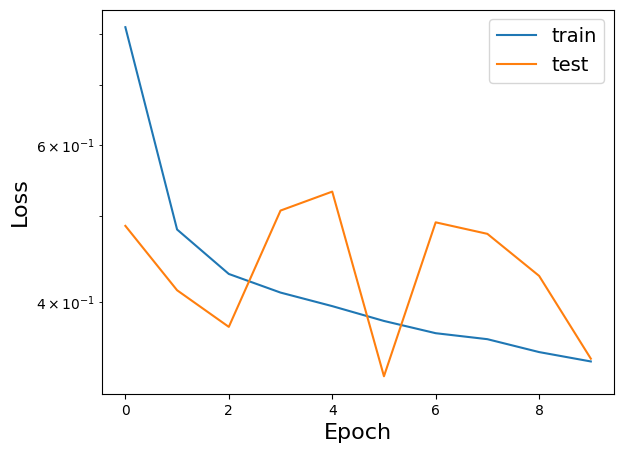

In [61]:
# These values are called hyperparameters and are the 'dials' that we can turn
# to try to improve the model's performance

BATCH_SIZE = 512 # how many examples are shown to the network at a time
NUM_EPOCHS = 10 # number of times the model sees the full dataset
LEARNING_RATE = 0.005 # how much the neurons adjust their weights

model.apply(reset_weights)

# this trains the model, it should take around 10 seconds per epoch
# an epoch means a full pass over the entire dataset
model, log = train_model(
  model, train_data, test_data, NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE
)

plot_learning_curves(log)

[__Question__] Do you observe [overfitting](https://www.ibm.com/cloud/learn/overfitting)?

[__Optional__] Try adjusting the hyperparameters.  For example, what happens when you double `LEARNING_RATE`?

# 4. Evaluate Trained Model
Now we find the accuracy of the trained model at classifying digits. By looking at some example predictions, you may get some insight into why the model makes mistakes.

In [66]:
def compute_statistics(model, data):
  labels = data.targets
  loader = DataLoader(data, batch_size=256)

  pred_labels = []
  for imgs, _ in loader:
    pred_labels.append(model(imgs.cuda()).max(1)[1].detach().cpu())

  pred_labels = torch.cat(pred_labels)

  is_correct = (labels == pred_labels).float()
  for i in range(10):
    ind = labels == i
    acc = torch.mean( is_correct[ind] )
    print(f'{LABELS[i]: <12}: {acc:.2%} accuracy')

  total_acc = torch.mean( is_correct )
  print(30*'-')
  print(f'Total       : {total_acc:.2%} accuracy')


DATA = test_data
# DATA = train_data
compute_statistics(model, DATA)

t-shirt     : 78.10% accuracy
trouser     : 96.00% accuracy
pullover    : 65.20% accuracy
dress       : 89.70% accuracy
coat        : 81.10% accuracy
sandal      : 96.70% accuracy
shirt       : 66.60% accuracy
sneaker     : 90.20% accuracy
bag         : 96.00% accuracy
boot        : 93.20% accuracy
------------------------------
Total       : 85.28% accuracy


[__Question__] What clothing items are hardest to classify? Is there an explanation for this?

[__Question__] What accuracy would you expect if the model had not learned anything?

[__Question__] Do you think the accuracy would be higher or lower for images from the training data? (try it yourself by setting `DATA` to `train_data` above)

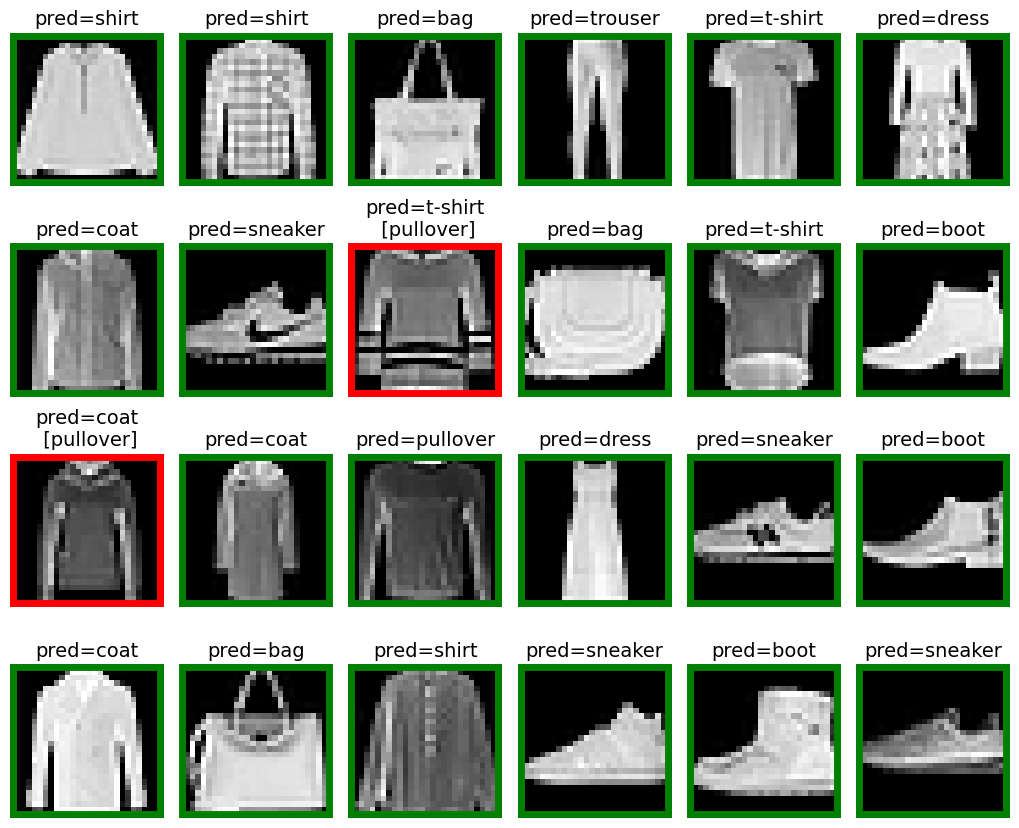

In [67]:
def plot_predictions(model, data):
  from matplotlib.patches import Rectangle
  loader = DataLoader(data, batch_size=24, shuffle=True)

  imgs, labels = next(iter(loader))
  pred_labels = model(imgs.cuda()).max(1)[1].detach().cpu()

  f, axs = plt.subplots(4,6, figsize=(10, 8))
  f.subplots_adjust(0,0,1,1, wspace=0.1, hspace= 0.25)

  for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i,0], cmap='gray')
    color = 'g' if pred_labels[i] == labels[i] else 'r'
    ax.add_patch(Rectangle((0,0), 1, 1, fc='none', ec=color, lw=10, transform=ax.transAxes))

    title = f'pred={LABELS[pred_labels[i]]}'
    if pred_labels[i] != labels[i]:
      title += f'\n [{LABELS[labels[i]]}]'
    ax.set_title(title, fontsize=14)
    ax.axis('off')
  plt.show()

# running this cell again will show new examples
plot_predictions(model, test_data)

[__Question__] Do you see any patterns in the wrong predictions?

[__Question__] Do you think the model is as good as a human at recognizing clothing items?

**If you have time, go back up to the Model section and see if you can modify the network to improve the prediction accuracy**